SML-17 Workshop #2: 2b Evaluation of classifiers 

This week we'll be using the *SPAM base* dataset from the UCI machine learning dataset repository. This dataset comprises a few thousand emails that have been annotated as being spam or not, and the several features have been created from the email text (e.g., presence of certain important words and characters, too many CAPITALS etc.) Note that for many practical applications defining the features is one of the hardest and most important steps. Thankfully this has already been done for us, so we can deploy and evaluate our machine learning algorithms directly. 

Please see http://archive.ics.uci.edu/ml/datasets/Spambase for a full description of the dataset and feature definitions.

Please follow the instructions from the previous lab for importing numpy etc, e.g.,

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


### Loading the SPAM data

The first step is to load the data, which we'll download from
http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data

In [2]:
# download the datafile

import sys 
if sys.version_info[0] >= 3:
    from urllib.request import urlretrieve
else:
    from urllib import urlretrieve

#url = "https://staffwww.dcs.shef.ac.uk/people/T.Cohn/campus_only/mlai13/spambase.data.data"
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
urlretrieve(url, 'spambase.data.data')


# load the CSV file as an array
Xandt = np.loadtxt('spambase.data.data', delimiter=',')
# randomly shuffle the rows, so as to remove any order bias 
np.random.shuffle(Xandt)

# the last column are the response labels (targets), 0 = not spam, 1 = spam
# remap into -1 and +1 and take only the first 500 examples
t = Xandt[:500,-1] * 2 - 1
# and the remaining columns are the data
X = Xandt[:500,:-1]

print("Loaded", X.shape, "data points, and", t.shape, "labels,",  t.min() , t.max())

Loaded (500, 57) data points, and (500,) labels, -1.0 1.0


The data has many different types of features, operating on different ranges and with overall very different distributions. Therefore, it is important to standardise each feature. Also, assumptions about the distributions of the input features are central to proofs of the generalisation bounds of several machine learning algorithms.

Inspect the minimum, maximum, mean and standard deviation for each column, using `np.mean` and `np.std`. Note that you'll need to supply an axis if you're just interested in columns, e.g., 

In [3]:
tmp = np.mean(X, 0)
print(np.round(tmp,2))
print('Num of features : ' , len(tmp))


[  1.20000000e-01   2.20000000e-01   3.00000000e-01   8.00000000e-02
   3.10000000e-01   9.00000000e-02   9.00000000e-02   1.10000000e-01
   1.10000000e-01   2.40000000e-01   6.00000000e-02   5.00000000e-01
   9.00000000e-02   6.00000000e-02   6.00000000e-02   2.50000000e-01
   1.50000000e-01   2.00000000e-01   1.70000000e+00   9.00000000e-02
   8.20000000e-01   1.40000000e-01   9.00000000e-02   1.20000000e-01
   6.10000000e-01   2.40000000e-01   1.07000000e+00   1.20000000e-01
   1.10000000e-01   1.10000000e-01   8.00000000e-02   6.00000000e-02
   1.20000000e-01   6.00000000e-02   1.30000000e-01   1.20000000e-01
   1.10000000e-01   1.00000000e-02   7.00000000e-02   7.00000000e-02
   6.00000000e-02   1.00000000e-01   5.00000000e-02   5.00000000e-02
   2.60000000e-01   2.00000000e-01   1.00000000e-02   4.00000000e-02
   4.00000000e-02   1.30000000e-01   1.00000000e-02   2.20000000e-01
   7.00000000e-02   4.00000000e-02   5.60000000e+00   4.86600000e+01
   2.80380000e+02]
Num of features

Note that the last three features have mean orders of magnitude greater than the other features. (Take a look at their definitions.) Thus, we will standardise all features to have mean 0 and standard deviation 1.

In [4]:
X = (X - np.mean(X, 0)) / np.std(X, 0)

Note that in previous labs we've plotted the data to get a feeling for how easily the data might be modelled, e.g., if it's linearly separable or requires polynomial basis functions etc. This technique is fine for data with 1 or 2 dimensions, but isn't so straight-forward for 57 dimensional data. (Note that dimensionality reduction methods, such as PCA, can be used to find the most important dimensions for viewing or exploiting in other learning algorithms.). 

### K-nearest neighbour classifier

To mix things up, for this session we will use a k-NN classifier. This classifier is incredibly simple: for each test point find the closest few ($k$) points in the training sets and return the majority label from these points. We will compare the setting of $k$, to try and find the *best* classifier.

Let's start by defining a function *euclidean* to calculate the euclidean distance, $d(\mathbf{x}, \mathbf{z}) = \sqrt{(\mathbf{x} - \mathbf{z})^T (\mathbf{x} - \mathbf{z})}$.

In [5]:
def euclidean(x, z):
    d = x - z
    if len(d.shape) > 1 and d.shape[1] > 1:
        return np.sqrt(np.diag(np.dot(d, d.T)))
    else:
        return np.sqrt(np.dot(d, d))

Next, define a function to find nearby training points for a given test point under the euclidean distance. You may want to use `np.argsort` which returns the sort order (as an array indices) for an input array.

In [6]:
def neighbours(x, train_x, k):
    dists = euclidean(train_x, x)
    return np.argsort(dists)[:k]

Note that this returns the indices of the training points, which can be used to look up the label. Now define the *k-NN* prediction algorithm, which processes each test point and finds the majority class of its neighbours in the training set.

In [7]:
def knn(test_x, train_x, train_t, k):
    predict = np.zeros(test_x.shape[0])
    for i in range(test_x.shape[0]):
        ns = neighbours(train_x, test_x[i], k)
        predict[i] = np.sign(np.sum(train_t[ns]))
    return predict

### Heldout evaluation

We have a large dataset of 500 examples. If we were to use all of these for training, we would have nothing left with which to evaluate the *generalisation error*. Recall that models often *overfit* the training sample, and therefore their performance on this set is often misleading: we have no way of telling if this is due to modelling the true problem or just fitting noise and other idiosyncracies of the training sample.

To illustrate, compute the *training error* of the approach with a few different values of $k$, `[1,3,9,15,33,77]`. We'll later see if other evaluation methods lead to different conclusions.

In [8]:
for k in [1,3,9,15,33,77]:
    print('%d-nn' % k, np.sum(knn(X, X, t, k) != t) / float(X.shape[0]))

1-nn 0.0
3-nn 0.072
9-nn 0.118
15-nn 0.116
33-nn 0.152
77-nn 0.2


What is going on? Which value of k is best?

#### Attempt 1: fixed validation set

Now we'll try evaluating on *heldout validation* data. This has been excluded from training, so the model cannot *overfit*. Instead this serves as a fresh data sample, which reflects the intended usage of the classifier in a live scenario (i.e., processing new emails as they arrive in your inbox).

One of the easiest methods is to slice the data into two parts. We'll half for training and half for testing. Note that these numbers are fairly arbitrary, but we do want enough test data to get a reliable error estimate.

In [9]:
N = X.shape[0]
cut = int(N/2)
Xtrain = X[:cut,:]
ttrain = t[:cut]
Xtest = X[cut:,:]
ttest = t[cut:]
print("There are", Xtrain.shape, "training samples, and", Xtest.shape, "heldout test samples")

There are (250, 57) training samples, and (250, 57) heldout test samples


In [10]:
print("Test split: for class label 1: ", np.sum(ttest ==1), "and class label -1", np.sum(ttest ==-1))
print("Train split: for class label 1: ", np.sum(ttrain ==1), "and class label -1", np.sum(ttrain ==-1))

Test split: for class label 1:  88 and class label -1 162
Train split: for class label 1:  105 and class label -1 145


Now your job is to apply $k$-NN on this data for the various values of $k$, and evaluate their training and heldout error.

In [11]:
# IMPLEMENT ME
for k in [1,3,9,15,33,77]:
    print('%d-nn' % k ,'training error', 
          np.sum(knn(Xtrain, Xtrain, ttrain, k) != ttrain) / float(Xtrain.shape[0]),'heldout error', 
          np.sum(knn(Xtest, Xtrain, ttrain, k) != ttest) / float(Xtest.shape[0]))

1-nn training error 0.0 heldout error 0.24
3-nn training error 0.084 heldout error 0.164
9-nn training error 0.14 heldout error 0.136
15-nn training error 0.16 heldout error 0.144
33-nn training error 0.164 heldout error 0.188
77-nn training error 0.308 heldout error 0.256


Is the heldout error similar to the training error, or do you notice consistent differences?  Can you explain why? What classifier might you select now, and does this match your earlier choice?

Good going. We now have a decent spam classifier, similar to the ones in Google and other email providers (which are trained on *much* more data). You could fairly easily take this approach and the feature definitions and plug this into your own email inbox to classify incoming mails.  Note that scaling this up to the full dataset would require a bit of engineering (or patience!), but otherwise would be straightforward.

#### Attempt 2: Leave-one-out cross validation

Another validation method is *cross-validation*, which is particularly suitable when you have only a small amount of data. This technique divides the data into parts, called *folds*. Then each fold is used for evaluation, and the model is trained on all other folds. This is repeated, such that we have heldout predictions for the entire dataset.

The leave-one-out method is the most extreme version of cross-validation, and defines each fold as a single data-point.

Implement k-NN to work using the leave-one-out method. This only requires a small change from the `knn()` method in order exclude the current point from consideration in the inner loop. Hint: start by taking the $k+1$ nearest neighbours, and then correct the result.

In [12]:
def knn_LOO(x, t, k):
    predict = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        ns = neighbours(x, x[i], k+1)
        if i in ns:
            predict[i] = np.sign(np.sum(t[ns]) - t[i])
        else:
            ns = ns[:k]
            predict[i] = np.sign(np.sum(t[ns]))
    return predict
# Another Implementation by Yasmeen 
def knn_LOO1(x, t, k):
    predict = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        xtrain = np.delete(x, (i), axis=0)
        ttrain = np.delete(t, (i), axis=0)
        xtest = x[i]
        ttest = t[i]
        ns = neighbours(xtrain, xtest, k)
        #print(xtrain.shape , ttrain.shape,xtest.shape, ttest, np.sign(np.sum(t[ns])))
        predict[i] = np.sign(np.sum(ttrain[ns]))
        
    return predict

Try this out for a few values of k, and compare their error rates. How do these values compare to your results from using a fixed validation set? Are they more reliable, and would you expect the cross-validation error to be higher or lower?

In [13]:
for k in [1,3,9,15,33,77]:
    print('%d-nn' % k, 
          'LOO error', np.sum(knn_LOO1(X, t, k) != t) / float(X.shape[0]))

1-nn LOO error 0.162
3-nn LOO error 0.164
9-nn LOO error 0.146
15-nn LOO error 0.136
33-nn LOO error 0.156
77-nn LOO error 0.206


In [14]:
for k in [1,3,9,15,33,77]:
    print('%d-nn' % k, 
          'LOO error', np.sum(knn_LOO(X, t, k) != t) / float(X.shape[0]))

1-nn LOO error 0.162
3-nn LOO error 0.164
9-nn LOO error 0.146
15-nn LOO error 0.136
33-nn LOO error 0.156
77-nn LOO error 0.206


## Error types and ROC analysis

Spam classification is an interesting test case. Consider the impact on an email user of various errors:

1. misclassifying a spam email as good 
1. misclassifying a good email as spam 

We need to balance annoyance (1) with missing potentially important information (2). 

These two errors are referred to as Type I and Type II errors, and are treated uniformly when measuring accuracy (and 0/1 loss). In this case it is more informative to evaluate the outputs by counting each of the four categories: true positives (true spam which was classified as spam), false positives (good classified as spam), true negatives (good classified as good), and false negatives (spam classified as good).

In [15]:
pred = knn_LOO(X, t, 9)
print('true positives ', np.sum(t[pred == 1] == 1))
print('false positives', np.sum(t[pred == 1] == -1))
print('true negatives ', np.sum(t[pred == -1] == -1))
print('false negatives', np.sum(t[pred == -1] == 1))

true positives  144
false positives 24
true negatives  283
false negatives 49


This shows that the data are skewed, i.e. there are more negatives than positives. Are the numbers of the two types of error are closely balanced?

The ROC curve gives a better view of the compromise between the two error types. This graph shows the relationship between the *false positive rate* and *true positive rate*. Each point on the curve represents a different classifier. In our case we can vary the value of k, recording the FPR and TPR at each point. Randomly guessing will give us a straight line in ROC space, and we seek to do better by being above and left (higher TPR for a given FPR; lower FPR for a given TPR). For a thorough description please read the wikipedia page on ROC analysis http://en.wikipedia.org/wiki/Receiver_operating_characteristic

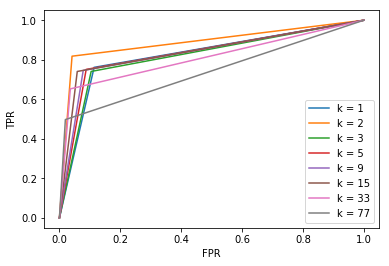

In [22]:
fprs = []
tprs = []

for k in [1,2,3,5,9,15,33,77]:
    pred = knn_LOO(X, t, k)
    
    tp = np.sum(t[pred==1] == 1)
    fp = np.sum(t[pred==1] == -1)
    tn = np.sum(t[pred==-1] == -1)
    fn = np.sum(t[pred==-1] == 1)
    
    # now compute the TPR and FPR
    fpr = fp / float(fp + tn)
    tpr = tp / float(tp + fn)
    
    plt.plot([0,fpr,1],[0,tpr,1],label='k = %d'%k)
    fprs.append(fpr)
    tprs.append(tpr)
plt.legend()
xlabel('FPR')
ylabel('TPR')

[0.11400651465798045, 0.041493775933609957, 0.10423452768729642, 0.087947882736156349, 0.078175895765472306, 0.058631921824104233, 0.035830618892508145, 0.019543973941368076] [0.76165803108808294, 0.81818181818181823, 0.7409326424870466, 0.75129533678756477, 0.74611398963730569, 0.7409326424870466, 0.65284974093264247, 0.49740932642487046]


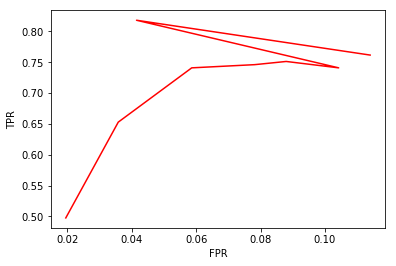

In [23]:
plot(fprs, tprs, 'r-')

xlabel('FPR')
ylabel('TPR')
print (fprs , tprs)

Depending on our appetite for false positive errors, we can read off the corresponding accuracy for predictions (TPR) with respect to false negatives. Plotting the ROC curve for several classifiers can help us choose which is best while incorporating unbalanced loss functions.